In [317]:
#import neccessary modules
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD, RMSprop

In [131]:
#load data
data = pd.read_excel(r"hit_ratio_model.xlsx",sheet_name=1)

In [132]:
#check data
data.head()

,ID,V_S_CARAGE,PH_ADD_S_REGION,PH_S_AGE,V_S_ENGCAPACITY,V_S_ENGPOWER,C_N_AZ_RANK,Q_N_SUCCESS,C_AZ_PREMIUM
0,1,01) 0,5 - Zilinsky,43) 57,06) 1300 - 1400,12) 90 - 95,11,1,100
1,2,06) 5,3 - Trenciansky,11) 25,12) 1900 - 2000,18) 130 - 140,11,1,220
2,3,06) 5,7 - Presovsky,43) 57,12) 1900 - 2000,14) 100 - 105,11,1,140
3,4,08) 7,7 - Presovsky,51) 65,08) 1500 - 1600,10) 80 - 85,11,1,110
4,5,13) 12,5 - Zilinsky,55) 69,08) 1500 - 1600,07) 65 - 70,11,1,190


In [167]:
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")
print(f"Number of duplicated rows: {data.duplicated().sum()}")

Number of rows: 1000
Number of columns: 9
Number of duplicated rows: 0


In [135]:
#check data types
data.dtypes

ID                  int64
V_S_CARAGE         object
PH_ADD_S_REGION    object
PH_S_AGE           object
V_S_ENGCAPACITY    object
V_S_ENGPOWER       object
C_N_AZ_RANK         int64
Q_N_SUCCESS         int64
C_AZ_PREMIUM        int64
dtype: object

In [145]:
#check number of bins 
data.nunique()

ID                 1000
V_S_CARAGE           22
PH_ADD_S_REGION       8
PH_S_AGE             58
V_S_ENGCAPACITY      15
V_S_ENGPOWER         21
C_N_AZ_RANK           9
Q_N_SUCCESS           2
C_AZ_PREMIUM        107
dtype: int64

In [146]:
#check number of missing values
data.isna().sum()

ID                 0
V_S_CARAGE         0
PH_ADD_S_REGION    0
PH_S_AGE           0
V_S_ENGCAPACITY    0
V_S_ENGPOWER       0
C_N_AZ_RANK        0
Q_N_SUCCESS        0
C_AZ_PREMIUM       0
dtype: int64

In [152]:
#get dummy variables out of variable Region
region_dummy = pd.get_dummies(data["PH_ADD_S_REGION"]).drop("8 - Kosicky",axis=1)
#exclude variable Region from data
data_NoRegion = data.drop("PH_ADD_S_REGION",axis=1)

In [151]:
region_dummy.head()

,1 - Bratislavsky,2 - Trnavsky,3 - Trenciansky,4 - Nitriansky,5 - Zilinsky,6 - Banskobystricky,7 - Presovsky
0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0


In [153]:
data_NoRegion.head()

,ID,V_S_CARAGE,PH_S_AGE,V_S_ENGCAPACITY,V_S_ENGPOWER,C_N_AZ_RANK,Q_N_SUCCESS,C_AZ_PREMIUM
0,1,01) 0,43) 57,06) 1300 - 1400,12) 90 - 95,11,1,100
1,2,06) 5,11) 25,12) 1900 - 2000,18) 130 - 140,11,1,220
2,3,06) 5,43) 57,12) 1900 - 2000,14) 100 - 105,11,1,140
3,4,08) 7,51) 65,08) 1500 - 1600,10) 80 - 85,11,1,110
4,5,13) 12,55) 69,08) 1500 - 1600,07) 65 - 70,11,1,190


In [158]:
#define function for extracting bin number from binned variable
def get_bin(val):
    ret = int(val.split(")")[0])
    return ret

In [164]:
#apply function get_bin on each binned variable
for col in data_NoRegion.columns:
    if data_NoRegion[col].dtype == object:
        data_NoRegion[col] = data_NoRegion[col].apply(get_bin)

In [165]:
data_NoRegion.head()

,ID,V_S_CARAGE,PH_S_AGE,V_S_ENGCAPACITY,V_S_ENGPOWER,C_N_AZ_RANK,Q_N_SUCCESS,C_AZ_PREMIUM
0,1,1,43,6,12,11,1,100
1,2,6,11,12,18,11,1,220
2,3,6,43,12,14,11,1,140
3,4,8,51,8,10,11,1,110
4,5,13,55,8,7,11,1,190


In [166]:
data_NoRegion.dtypes

ID                 int64
V_S_CARAGE         int64
PH_S_AGE           int64
V_S_ENGCAPACITY    int64
V_S_ENGPOWER       int64
C_N_AZ_RANK        int64
Q_N_SUCCESS        int64
C_AZ_PREMIUM       int64
dtype: object

In [168]:
#join data with dummy variables
data_AllTogether = pd.concat([data_NoRegion,region_dummy],axis=1)

In [169]:
data_AllTogether.head()

,ID,V_S_CARAGE,PH_S_AGE,V_S_ENGCAPACITY,V_S_ENGPOWER,C_N_AZ_RANK,Q_N_SUCCESS,C_AZ_PREMIUM,1 - Bratislavsky,2 - Trnavsky,3 - Trenciansky,4 - Nitriansky,5 - Zilinsky,6 - Banskobystricky,7 - Presovsky
0,1,1,43,6,12,11,1,100,0,0,0,0,1,0,0
1,2,6,11,12,18,11,1,220,0,0,1,0,0,0,0
2,3,6,43,12,14,11,1,140,0,0,0,0,0,0,1
3,4,8,51,8,10,11,1,110,0,0,0,0,0,0,1
4,5,13,55,8,7,11,1,190,0,0,0,0,1,0,0


[Text(0, 0.5, '')]

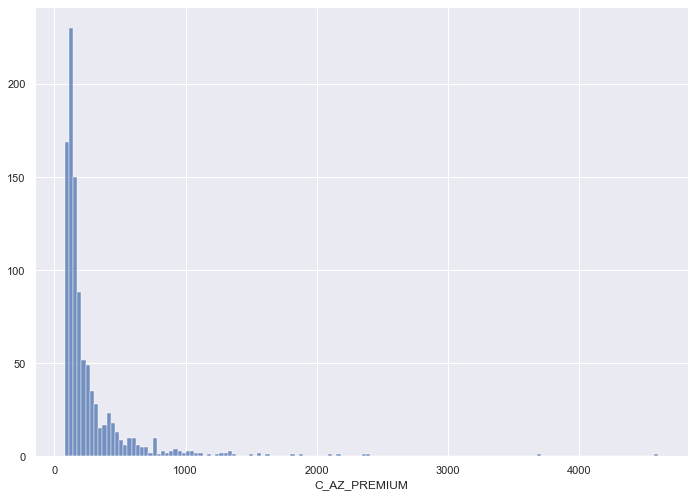

In [176]:
#check distribution of variable Premium
sns.set(style="darkgrid",rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data_AllTogether, x="C_AZ_PREMIUM").set(ylabel = None)

In [177]:
data_AllTogether["C_AZ_PREMIUM"].describe()

count    1000.000000
mean      272.190000
std       323.209171
min        80.000000
25%       130.000000
50%       160.000000
75%       290.000000
max      4600.000000
Name: C_AZ_PREMIUM, dtype: float64

In [186]:
#define function for outlier detection
def outlier_detection(col,multiplier=1.5):
    q_low = col.quantile(0.1)
    q_hi  = col.quantile(0.9)
    diff = q_hi - q_low
    lower = q_low - multiplier*diff
    upper = q_hi + multiplier*diff
    ret = col[(col > upper) | (col < lower)]
    return ret

In [187]:
#print out potential outliers - in this case, we do not provide any specific modifications to them
outlier_detection(data_AllTogether["C_AZ_PREMIUM"])

32     1620
61     1380
63     2090
73     2170
81     1340
88     1560
97     2390
130    2360
237    1310
394    1350
396    1810
588    1290
693    1350
733    1260
784    1570
817    4600
821    3680
832    1510
833    1240
845    1890
859    1260
Name: C_AZ_PREMIUM, dtype: int64

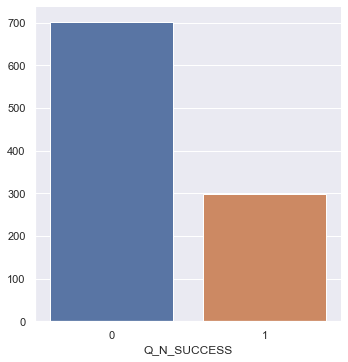

In [189]:
#check distribution of dependent variable - we can see an imbalance
sns.catplot(data=data_AllTogether, x="Q_N_SUCCESS",kind="count").set(ylabel = None)

In [191]:
#get correlation matrix 
data_AllTogether.drop("ID",axis=1).corr()

,V_S_CARAGE,PH_S_AGE,V_S_ENGCAPACITY,V_S_ENGPOWER,C_N_AZ_RANK,Q_N_SUCCESS,C_AZ_PREMIUM,1 - Bratislavsky,2 - Trnavsky,3 - Trenciansky,4 - Nitriansky,5 - Zilinsky,6 - Banskobystricky,7 - Presovsky
V_S_CARAGE,1.000000,-0.041168,0.191534,-0.366000,-0.105496,0.378012,-0.171835,-0.093524,0.025521,0.042000,0.030258,-0.031399,0.080413,-0.035485
PH_S_AGE,-0.041168,1.000000,-0.164073,-0.135760,0.207001,-0.061661,-0.076081,0.074494,0.013203,0.019889,0.023136,-0.096530,-0.023848,-0.033315
V_S_ENGCAPACITY,0.191534,-0.164073,1.000000,0.628592,0.267232,0.032602,0.069312,-0.034802,-0.032943,-0.040639,-0.006292,0.017290,-0.012217,0.060410
V_S_ENGPOWER,-0.366000,-0.135760,0.628592,1.000000,0.218220,-0.156019,0.186089,0.042234,-0.036167,-0.001327,-0.046166,0.018095,-0.068951,0.040549
C_N_AZ_RANK,-0.105496,0.207001,0.267232,0.218220,1.000000,-0.029481,0.009982,-0.159765,0.097825,0.032637,0.126518,0.017081,0.057123,-0.043579
Q_N_SUCCESS,0.378012,-0.061661,0.032602,-0.156019,-0.029481,1.000000,-0.250973,-0.416942,0.067049,0.102214,0.080103,0.116058,0.164623,0.095808
C_AZ_PREMIUM,-0.171835,-0.076081,0.069312,0.186089,0.009982,-0.250973,1.000000,0.223068,-0.025167,-0.062314,-0.074796,-0.053249,-0.053216,-0.099857
1 - Bratislavsky,-0.093524,0.074494,-0.034802,0.042234,-0.159765,-0.416942,0.223068,1.000000,-0.290109,-0.263557,-0.247823,-0.260117,-0.211978,-0.321390
2 - Trnavsky,0.025521,0.013203,-0.032943,-0.036167,0.097825,0.067049,-0.025167,-0.290109,1.000000,-0.100942,-0.094916,-0.099624,-0.081187,-0.123091
3 - Trenciansky,0.042000,0.019889,-0.040639,-0.001327,0.032637,0.102214,-0.062314,-0.263557,-0.100942,1.000000,-0.086229,-0.090506,-0.073756,-0.111826


In [192]:
x = data_AllTogether.drop(["ID","Q_N_SUCCESS"],axis=1)
y = data_AllTogether["Q_N_SUCCESS"]

In [194]:
#split data between training and validation sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [195]:
#cross validate the hyperparameters on random forest model
par_rfr = {"max_depth":[5,6,7],"max_features":[11,12,13],"min_samples_leaf":[2,3,4]}
rfr = RandomForestClassifier()
gscv = GridSearchCV(rfr,par_rfr)
gscv.fit(x_train,y_train)
#select best HPs
p_1_rfr = gscv.best_params_["max_depth"]
p_2_rfr = gscv.best_params_["max_features"]
p_3_rfr = gscv.best_params_["min_samples_leaf"]
#fit random forest with best HPs
rfr = RandomForestClassifier(max_depth= p_1_rfr,max_features=p_2_rfr,min_samples_leaf=p_3_rfr)
rfr.fit(x_train,y_train)
#predict classes and probabilities
y_p_rfr = rfr.predict(x_test)
y_prob_rfr = rfr.predict_proba(x_test)

In [196]:
print(f"test accuracy: {accuracy_score(y_p_rfr,y_test)}, ROC AUC: {roc_auc_score(y_test,y_prob_rfr[:, 1])}, max depth: {p_1_rfr}, max features: {p_2_rfr}, min sample leaf: {p_3_rfr}")

test accuracy: 0.8266666666666667, ROC AUC: 0.8880684026428294, max depth: 7, max features: 11, min sample leaf: 2


Text(0.5, 1.0, 'Feature importances')

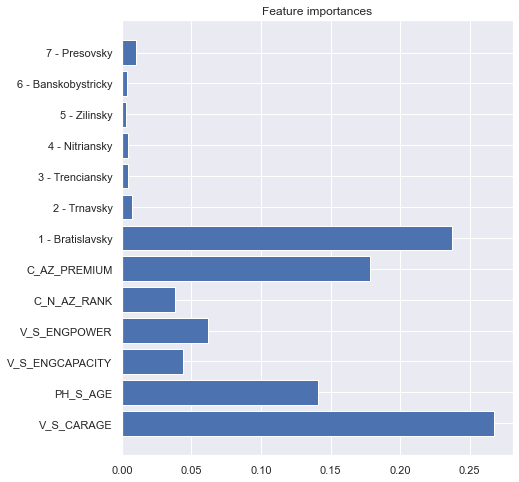

In [201]:
#plot feature importances - we see that we can discriminate only whether or not client is from Bratislavsky kraj
plt.figure(figsize=(7,8))
plt.barh(x.columns, rfr.feature_importances_)
plt.title("Feature importances")

In [202]:
par_gbm = {"learning_rate":[0.01,0.1,0.3,0.5],"min_samples_leaf":[2,3,4]}
gbm = GradientBoostingClassifier()
gscv = GridSearchCV(gbm,par_gbm)
gscv.fit(x_train,y_train)
p_1_gbm = gscv.best_params_["learning_rate"]
p_2_gbm = gscv.best_params_["min_samples_leaf"]
gbm = GradientBoostingClassifier(learning_rate= p_1_gbm,min_samples_leaf=p_2_gbm)
gbm.fit(x_train,y_train)
y_p_gbm = gbm.predict(x_test)
y_prob_gbm = gbm.predict_proba(x_test)

In [203]:
print(f"test accuracy: {accuracy_score(y_p_gbm,y_test)}, ROC AUC: {roc_auc_score(y_test,y_prob_gbm[:, 1])}, learning_rate: {p_1_gbm}, min sample leaf: {p_2_gbm}")

test accuracy: 0.8333333333333334, ROC AUC: 0.9024485036921881, learning_rate: 0.1, min sample leaf: 2


Text(0.5, 1.0, 'Feature importances')

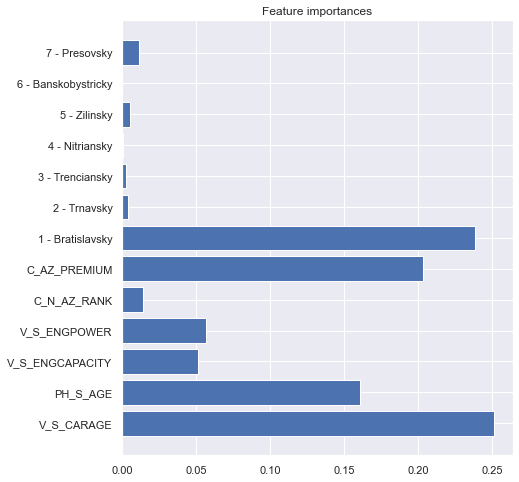

In [206]:
plt.figure(figsize=(7,8))
plt.barh(x.columns, gbm.feature_importances_)
plt.title("Feature importances")

In [271]:
#create callback which will stop training process of neural net,when it reaches desired level of accuracy
class StopOnPoint(tf.keras.callbacks.Callback):
    def _init_(self):
        super(StopOnPoint,self)._init_()
        #self.point = point
        
    def on_epoch_end(self, epoch, logs =None):
        accuracy = logs["accuracy"]
        val_accuracy = logs["val_accuracy"]
        if accuracy >= 0.86 and val_accuracy >= 0.87:
            self.model.stop_training = True

In [274]:
#use sequential neural net
model = Sequential()
model.add(Dense(100,activation="relu",input_dim=13))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
SOP = StopOnPoint()
model.compile(optimizer=opt,loss="binary_crossentropy",metrics=['accuracy'])
fit = model.fit(x_train,y_train,epochs=100,validation_split=0.2,verbose=1,callbacks=[SOP])

Epoch 1/100
18/18 [==============================] - 2s 20ms/step - loss: 0.7131 - accuracy: 0.6732 - val_loss: 0.5997 - val_accuracy: 0.6857
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 0.5546 - accuracy: 0.7446 - val_loss: 0.4885 - val_accuracy: 0.7214
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.4611 - accuracy: 0.7750 - val_loss: 0.5247 - val_accuracy: 0.7429
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 0.4914 - accuracy: 0.7554 - val_loss: 0.6274 - val_accuracy: 0.7429
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.4602 - accuracy: 0.7625 - val_loss: 0.4210 - val_accuracy: 0.8214
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 0.4506 - accuracy: 0.7714 - val_loss: 0.4137 - val_accuracy: 0.8000
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 0.5343 - accuracy: 0.7679 - val_loss: 0.5252 - val_accuracy: 0.7714
Epoch 8/100


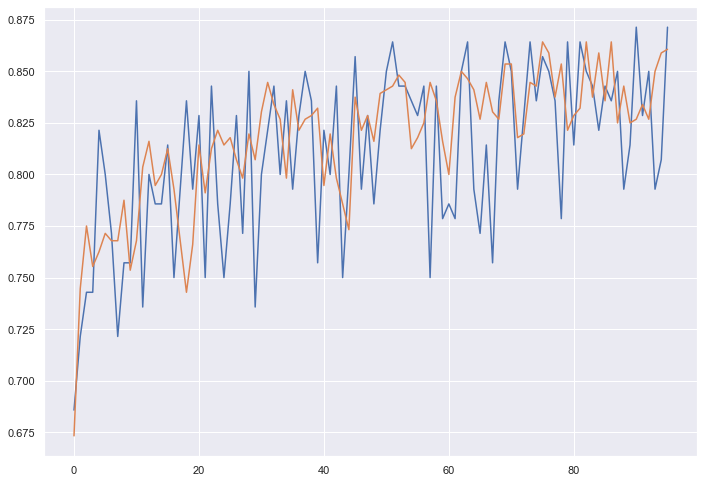

In [275]:
#plot development of training and validation accuracy across different epochs
plt.plot(fit.history['val_accuracy'])
plt.plot(fit.history['accuracy'])

In [283]:
#predict probabilities and classes
y_prob_nn = model.predict(x_test)
y_p_nn = [1 if i>= 0.5 else 0 for i in y_prob_nn]

In [285]:
print(f"test accuracy: {accuracy_score(y_p_nn,y_test)}, ROC AUC: {roc_auc_score(y_test,y_prob_nn)}")

test accuracy: 0.84, ROC AUC: 0.8847926267281105


In [292]:
fpr_rfr, tpr_rfr, treshold_rfr = roc_curve(y_test,y_prob_rfr[:, 1])
fpr_gbm, tpr_gbm, treshold_gbm = roc_curve(y_test,y_prob_gbm[:, 1])
fpr_nn, tpr_nn, treshold_nn = roc_curve(y_test,y_prob_nn)

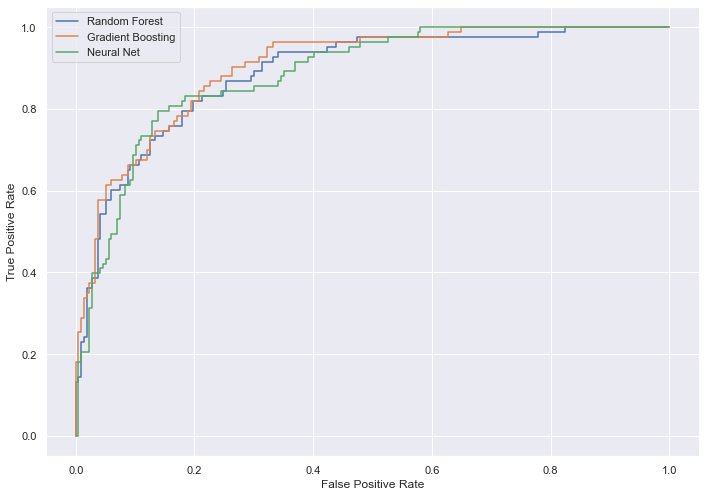

In [291]:
#create ROC curve for all 3 models
plt.plot(fpr_rfr,tpr_rfr,label="Random Forest")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(fpr_gbm,tpr_gbm,label="Gradient Boosting")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(fpr_nn,tpr_nn,label="Neural Net")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [353]:
#define function for findig optimal cuttof based on ROC
def opt_treshold(tpr,fpr,treshold):
    opt_idx = np.argmax(tpr - fpr)
    opt_treshold = treshold[opt_idx]
    return opt_treshold

In [354]:
opt_treshold_rfr = opt_treshold(tpr_rfr,fpr_rfr,treshold_rfr)
opt_treshold_gbm =  opt_treshold(tpr_gbm,fpr_gbm,treshold_gbm)
opt_treshold_nn =  opt_treshold(tpr_nn,fpr_nn,treshold_nn)

In [325]:
def percent_CM(pred):
    CM = confusion_matrix(y_test,pred)
    return CM/np.sum(CM)

In [351]:
#get predicted classes for each model with its optimal ROC cutoff
pred_opt_tr_rfr = [1 if i >= opt_treshold_rfr else 0 for i in y_prob_rfr[:, 1]]
pred_opt_tr_gbm= [1 if i >= opt_treshold_gbm else 0 for i in y_prob_gbm[:, 1]]
pred_opt_tr_nn = [1 if i >= opt_treshold_nn else 0 for i in y_prob_nn]

In [336]:
CM_rfr_opt = percent_CM(pred_opt_tr_rfr)
CM_gbm_opt = percent_CM(pred_opt_tr_gbm)
CM_nn_opt = percent_CM(pred_opt_tr_nn)

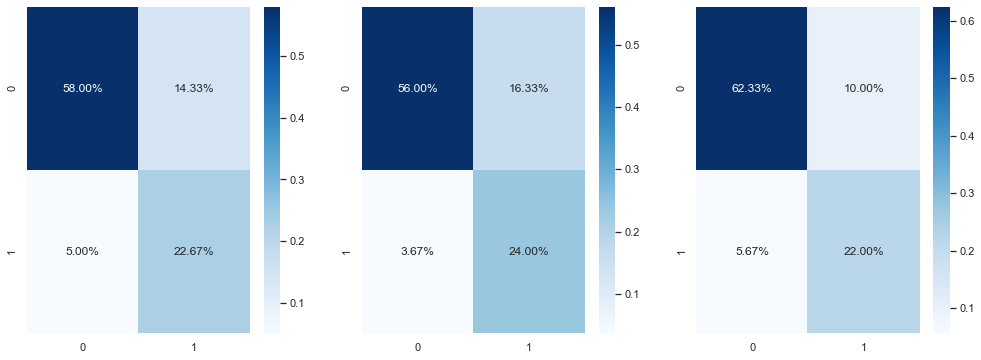

In [337]:
#plot percentual confusion matrices
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,6))
sns.heatmap(CM_rfr_opt, annot=True, fmt='.2%', cmap='Blues',ax=ax1)
sns.heatmap(CM_gbm_opt, annot=True, fmt='.2%', cmap='Blues',ax=ax2)
sns.heatmap(CM_nn_opt, annot=True, fmt='.2%', cmap='Blues',ax=ax3)
plt.show()

In [355]:
print(f"Random Forest accuracy of {accuracy_score(pred_opt_tr_rfr,y_test)} on cut off {opt_treshold_rfr}")
print(f"Gradient Boosting accuracy of {accuracy_score(pred_opt_tr_gbm,y_test)} on cut off {opt_treshold_gbm}")
print(f"Neural Net accuracy of {accuracy_score(pred_opt_tr_nn,y_test)} on cut off {opt_treshold_nn}")

Random Forest accuracy of 0.8066666666666666 on cut off 0.29489125292884233
Gradient Boosting accuracy of 0.8 on cut off 0.22499683875626145
Neural Net accuracy of 0.81 on cut off 0.4929178059101105


In [362]:
#get answer on your question
array = np.array([7,14,8,8,5,120,1,0,0,0,0,0,0])
print(f"Probability of success for the quotation is ", gbm.predict_proba(array.reshape(1,-1))[0][1])

Probability of success for the quotation is  0.6343261243726487
